In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
import os
from tqdm import tqdm_notebook as tqdm
from keras import backend as K

from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.utils import plot_some
from csbdeep.data import RawData, create_patches
from csbdeep.io import load_training_data
from keras.models import load_model
from networks.layers import MaxPoolingWithArgmax2D, MaxUnpooling2D

Using TensorFlow backend.
c:\users\nuno martins\appdata\local\conda\conda\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\nuno martins\appdata\local\conda\conda\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\nuno martins\appdata\local\conda\conda\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

In [2]:
limit_gpu_memory(fraction=2/3)

## For reloading model from Segnet (with custom layers)

In [2]:
model = load_model('test_models/mysegnet_crossentropyloss_sigmoidactivation_sgd_20200512_2331.h5', custom_objects={'MaxPoolingWithArgmax2D': MaxPoolingWithArgmax2D, 'MaxUnpooling2D':MaxUnpooling2D})
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
_______________________________________________________

## For reloading model from UNet

In [ ]:
model = load_model('test_models/myunet_mseloss_linearactivation_adam_20200508_2216.h5')
model.summary()

### Step by step procedure of visualizing filters

In [4]:
layer_name = 'conv2d_1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [5]:
grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [6]:
iterate = K.function([model.input], [loss, grads])

loss_value , grads_value = iterate([np.zeros((1, 128, 128, 1))])

In [7]:
input_img_data = np.random.random((1, 128, 128, 1))
# plt.figure()
# plt.imshow(input_img_data[0, :, :, 0])

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value*step

## Loop and functions to visualize filters
### Function to normalize image

In [3]:
def deprocess_image(temp_img):
    temp_img -= temp_img.mean()
    temp_img /= (temp_img.std() + 1e-5)
    temp_img *= 0.1 
    
    temp_img += 0.5
    temp_img = np.clip(temp_img, 0, 1)
    
    temp_img *= 255
    temp_img = np.clip(temp_img, 0, 255).astype('uint8')
    return temp_img


### Function to generate filter

In [4]:
def generate_pattern(layer_name, filter_index, size = 128):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 1)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value*step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [ ]:
plt.imshow(generate_pattern('conv2d_26', 0)[:, :, 0])

### To visualize 64 filters in conv blocks

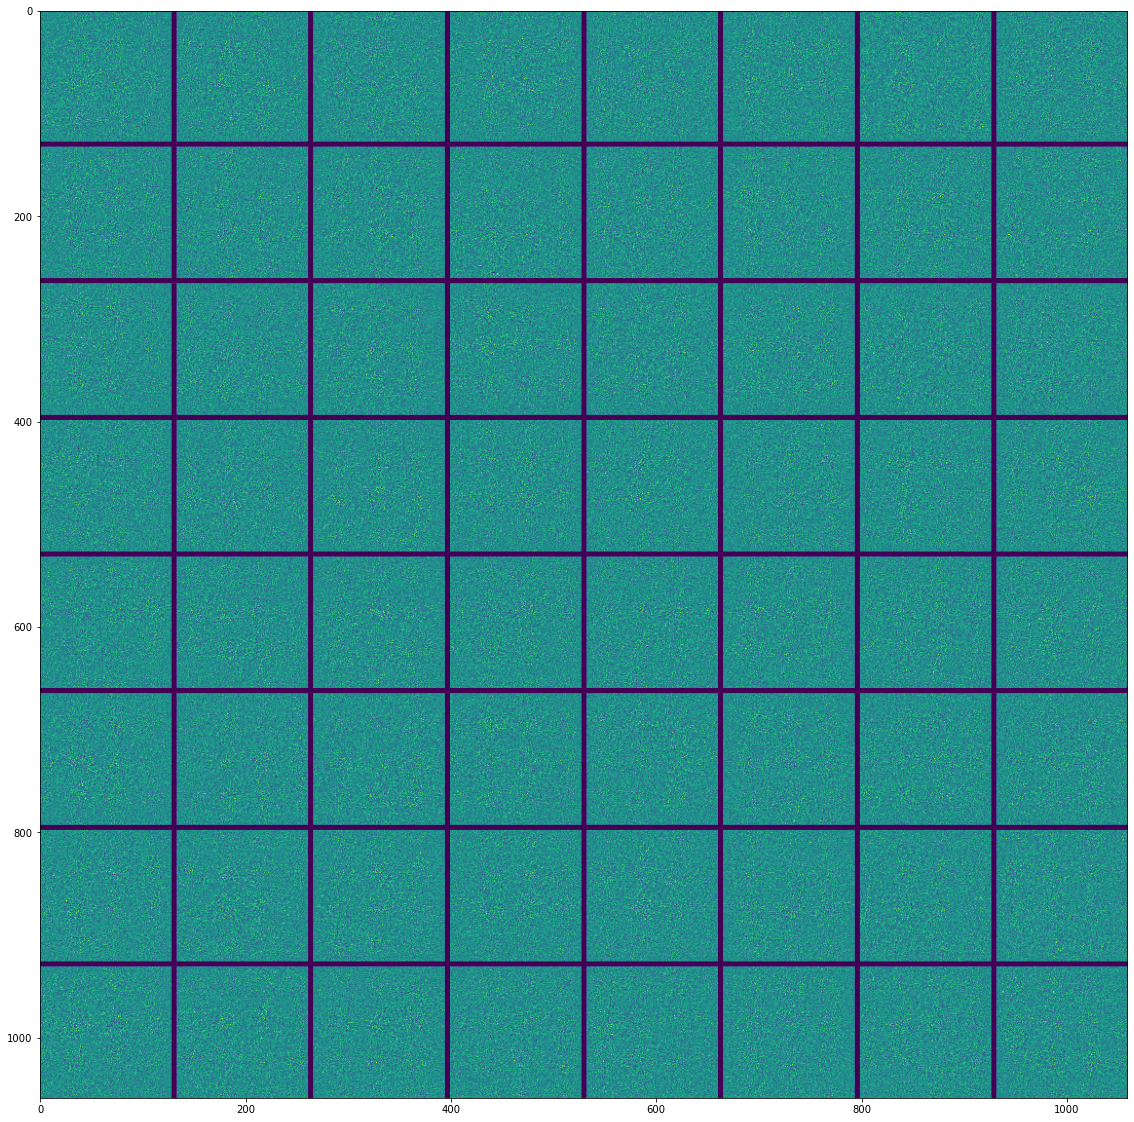

In [7]:
layer_name = 'conv2d_17'
size = 128
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 1))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start+size
        results[horizontal_start : horizontal_end, vertical_start : vertical_end, :] = filter_img

plt.figure(figsize = (20, 20))
plt.imshow(results[..., 0])